In [1]:
import os
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

from pandas.tseries.frequencies import to_offset

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator

from pandas.io.json import json_normalize
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#sns.set_context("paper", font_scale=1.3)
#sns.set_style('white')

import datetime
from dateutil.tz import tzutc
#https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb

In [2]:
print("This notebook was created using version 1.18.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.18.0 of the Azure ML SDK
You are currently using version 1.18.0 of the Azure ML SDK


In [3]:
#Definitions

today = pd.to_datetime('today').normalize()
current_eom = today + pd.offsets.MonthEnd(0)
start_date = "2017-01-01"
end_date = current_eom + pd.offsets.MonthEnd(11)
entity_debug = "GBR"
debug = True

def get_json(df):
    """ Small function to serialise DataFrame dates as 'YYYY-MM-DD' in JSON """

    def convert_timestamp(item_date_object):
        if isinstance(item_date_object, (datetime.date, datetime.datetime)):
            return item_date_object.strftime("%Y-%m-%d")
    
    dict_ = df.to_dict(orient="records")

    return json.dumps(dict_, default=convert_timestamp)

#display count and summary of any dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.precision', 1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def difflist(li1, li2): 
    return (list(set(li1) - set(li2)))

def addlist(li1, li2): 
    return (li1.append(li2))

def remove_percetage(df, column_list):
    for col in column_list:
        df[col] = round(df[col].str.replace('%','').astype(np.float64) / 100, 4)
    return df

def coerce_df_columns_to_numeric(df):
    cols_float1 = list(df.filter(like='Rate', axis=1).columns)
    cols_float2 = list(df.filter(like='Yield', axis=1).columns)
    cols_float3 = list(df.filter(like='Diff%', axis=1).columns)
    cols_float4 = list(df.filter(like='Relative_Offset', axis=1).columns)
    cols_float5 = list(df.filter(like='sp500', axis=1).columns)
    cols_float6 = list(df.filter(like='Return', axis=1).columns)
    cols_float = cols_float1 + cols_float2 + cols_float3 + cols_float4 + cols_float5 + cols_float6
    #display("cols_float:", cols_float)
    cols_int1 = list(df.filter(like='Revenue', axis=1).columns)
    cols_int2 = list(df.filter(like='Conversions', axis=1).columns)
    cols_int3 = list(df.filter(like='Value', axis=1).columns)
    cols_int4 = list(df.filter(like='Pipeline', axis=1).columns)
    cols_int5 = list(df.filter(like='Offset', axis=1).columns)
    cols_int6 = list(df.filter(like='Headcount', axis=1).columns)
    cols_int = cols_int1 + cols_int2 + cols_int3 + cols_int4 + cols_int5 + cols_int6
    #display("cols_int:", cols_int)
    cols1 = list(df.select_dtypes(include='float64').columns)
    cols = cols1 + cols_int
    #display("cols:", cols)
    final_cols = difflist(cols,cols_float)
    #display("final_cols:", final_cols)
    df[final_cols] = df[final_cols].apply(pd.to_numeric, errors='coerce')
    df[final_cols] = df[final_cols].replace(np.nan, 0, regex=True)
    df[final_cols] = df[final_cols].astype(int)
    df[final_cols] = round(df[final_cols],0)
    #return df

def data_prep(df):
    df.columns = df.columns.astype(str).str.replace(" ", "_")
    if 'End_of_Month' in df.columns:
        df['End_of_Month'] = pd.to_datetime(df['End_of_Month']) #Format Date
        #df = df.query('End_of_Month < @current_eom').reset_index(drop=True)
    if 'Snapshot_Date_Short' in df.columns:
        df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short']) #Format Date
    #df = df.query('Fin_Entity_ID not in @exclude_studio')
    df = df.query('Fin_Entity_ID not in ["SGP",0]') # Exclude Singapore rows
    df = df.replace(np.nan, 0, regex=True)
    return df

def show_stats(df):   
    print("\n DF Name: \n")
    display(get_df_name(df))
    print("\n DF Info: \n")
    display(df.info(verbose=True))
    print("\n DF Describe: \n")
    display(df.describe(include='all').transpose().head())
    print("\n DF Head: \n")
    display(df.head())
    print("\n DF Tail: \n")
    display(df.tail())
    group_by_entity = df.groupby(by=['Fin_Entity_ID'], as_index=False)
    entity_sum = group_by_entity.sum().reset_index(drop=True)
    entity_count = group_by_entity.count().reset_index(drop=True)
    print("\n Entity Sum: \n")
    display(entity_sum.head())
    print("\n Studio Count: \n")
    display(entity_count.head())
    if 'End_of_Month' in df.columns:
        df['End_of_Month'] = pd.to_datetime(df['End_of_Month']) #Format Date
        group_by_eom = df.groupby(by=['End_of_Month'], as_index=False)
        eom_sum = group_by_eom.sum().reset_index(drop=True)
        eom_count = group_by_eom.count().reset_index(drop=True)
        print("\n EOM Sum:")
        display(eom_sum.head())
        print("\n EOM Count: \n")
        display(eom_count.head())
    if 'Snapshot_Date_Short' in df.columns:
        df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short']) #Format Date
        group_by_sds = df.groupby(by=['Snapshot_Date_Short'], as_index=False)
        sds_sum = group_by_sds.sum().reset_index(drop=True)
        sds_count = group_by_sds.count().reset_index(drop=True)
        print("\n SDS Sum:")
        display(sds_sum.head())
        print("\n SDS Count: \n")
        display(sds_count.head())
    return

In [4]:
#read input files
time_column_name = 'End of Month'
time_column_name1 = 'Snapshot Date Short'
talenthist = pd.read_csv("TalentHistory.csv", parse_dates=[time_column_name])
pipehist = pd.read_csv("PipelineHistory.csv", parse_dates=[time_column_name,time_column_name1])
revhist = pd.read_csv("RevenueHistory.csv", parse_dates=[time_column_name])
opphist = pd.read_csv("OppHistory.csv", parse_dates=[time_column_name])
projhist = pd.read_csv("ProjectHistory.csv", parse_dates=[time_column_name])
time_column_name2 = 'Latest Snapshot Date Short'
pipetrend = pd.read_csv("PipelineTrend.csv", parse_dates=[time_column_name2])
display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())

,End of Month,Contrib Fin Entity ID,Headcount,Headcount Contingent
285,2021-10-31,CHN,28.00,4.00
286,2021-10-31,DEU,25.00,1.00
287,2021-10-31,GBR,42.00,4.00
288,2021-10-31,JPN,33.00,nan
289,2021-10-31,USA,406.55,14.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Fin Entity ID,Pipeline
6441,2020-11-24,0,2021-09-30,10,GBR,147321.43
6442,2020-11-24,0,2021-09-30,10,USA,508051.45
6443,2020-11-24,0,2021-10-31,11,DEU,46288.16
6444,2020-11-24,0,2021-10-31,11,GBR,140625.00
6445,2020-11-24,0,2021-10-31,11,USA,307448.39


,End of Month,Managing Fin Entity ID,Revenue
230,2020-11-30,USA,1115725.00
231,2020-12-31,USA,557736.30
232,2021-01-31,USA,1384196.00
233,2021-02-28,USA,1237579.00
234,2021-03-31,USA,1007371.00


,End of Month,Managing Fin Entity ID,Current Opp. Period Value
137,2020-11-30,CHN,696360.00
138,2020-11-30,DEU,1860520.80
139,2020-11-30,GBR,285560.00
140,2020-11-30,JPN,997500.00
141,2020-11-30,USA,9033001.00


,End of Month,Managing Fin Entity ID,Conversions
190,2020-11-30,CHN,927203.21
191,2020-11-30,DEU,97350.00
192,2020-11-30,GBR,703369.25
193,2020-11-30,JPN,550569.49
194,2020-11-30,USA,7052186.00


,Latest Snapshot Date Short,Relative Snapshot Month Offset,Contrib Fin Entity ID,Pipeline Trend
140,2020-11-24,0,CHN,10220057.04
141,2020-11-24,0,DEU,8982790.31
142,2020-11-24,0,GBR,14939343.08
143,2020-11-24,0,JPN,8170980.33
144,2020-11-24,0,USA,137386311.84



 SP500: 



'SP500'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 1 to 58
Data columns (total 4 columns):
End_of_Month         58 non-null datetime64[ns]
sp500                58 non-null float64
Monthly_Return       58 non-null float64
sp500_1M_Previous    58 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.3 KB


None


 SP500 Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,58,58,2017-11-30,1,2016-02-29,2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,58.000000,NaN,NaT,NaN,NaT,NaT,2687.651552,396.282683,1932.230000,2391.100000,2708.505000,2944.812500,3629.650000
Monthly_Return,58.000000,NaN,NaT,NaN,NaT,NaT,0.011813,0.043967,-0.125119,-0.001012,0.017520,0.033101,0.126844
sp500_1M_Previous,58.000000,NaN,NaT,NaN,NaT,NaT,2658.523793,387.826427,1932.230000,2368.780000,2704.685000,2937.935000,3500.310000



 SP500 Head: 



,End_of_Month,sp500,Monthly_Return,sp500_1M_Previous
1,2016-02-29,1932.230000,-0.004128,1940.240000
2,2016-03-31,2059.740000,0.065991,1932.230000
3,2016-04-30,2065.300000,0.002699,2059.740000
4,2016-05-31,2096.960000,0.015329,2065.300000
5,2016-06-30,2098.860000,0.000906,2096.960000



 SP500 Tail: 



,End_of_Month,sp500,Monthly_Return,sp500_1M_Previous
54,2020-07-31,3271.120000,0.055101,3100.290000
55,2020-08-31,3500.310000,0.070065,3271.120000
56,2020-09-30,3363.000000,-0.039228,3500.310000
57,2020-10-31,3269.960000,-0.027666,3363.000000
58,2020-11-30,3629.650000,0.109998,3269.960000


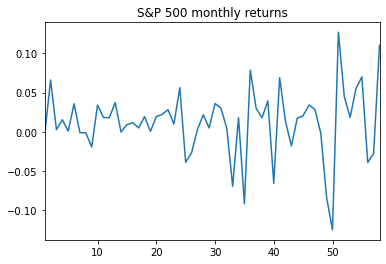

In [5]:
#download SP500 closing prices
#if you get an error after executing the code, try adding below. 
#!pip install pandas-datareader

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today
#pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
#SP500 = web.DataReader(['sp500'], 'fred', start, end)
#display(SP500.head())

import pandas_datareader as pdr

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE']+ pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()
SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)
SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print("\n SP500: \n")
display(get_df_name(SP500))
print("\n DF Info: \n")
display(SP500.info(verbose=True))
print("\n SP500 Describe: \n")
display(SP500.describe(include='all').transpose().head())
print("\n SP500 Head: \n")
display(SP500.head())
print("\n SP500 Tail: \n")
display(SP500.tail())
SP500['Monthly_Return'].plot(title='S&P 500 monthly returns')

In [6]:
#create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'revenue-time-forecast'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,db61fd47-db56-45e3-844f-1b1f5c47990a
Workspace,dwmlazwu01
SKU,Enterprise
Resource Group,BI-DevQA-RG
Location,westus2
Run History Name,revenue-time-forecast


In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
amlcompute_cluster_name = "cibimldev01"

compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
print('Found existing cluster, use it.')

Found existing cluster, use it.


In [8]:
#Rename Studio, filter studio and prep data
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#exclude_studio = ["Regional Bay Area", "Regional ChiCamNY", "Palo Alto", "Singapore", "Unknown", "North America"]

#display(exclude_studio)
talenthist1 = talenthist.copy()
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
talenthist1.columns = talenthist1.columns.astype(str).str.replace("Contrib ", "")
pipehist1.columns = pipehist1.columns.astype(str).str.replace("Contrib ", "")
pipetrend1.columns = pipetrend1.columns.astype(str).str.replace("Contrib ", "")
opphist1.columns = opphist1.columns.astype(str).str.replace("Managing ", "")
projhist1.columns = projhist1.columns.astype(str).str.replace("Managing ", "")
revhist1.columns = revhist1.columns.astype(str).str.replace("Managing ", "")
#talenthist1 = talenthist.rename(columns={"Contrib Studio Name": "Studio"})
#pipehist1 = pipehist.rename(columns={"Contrib Studio Name": "Studio"})

#revhist1 = revhist.rename(columns={"Managing Studio Name": "Studio"})
pipetrend1 = pipetrend1.rename(columns={"Latest Snapshot Date Short": "End of Month",
                                       #"Contrib Studio Name": "Studio", 
                                       "Relative Snapshot Month Offset": "Relative Month Offset"})
#opphist1 = opphist.rename(columns={"Managing Studio Name": "Studio"})
#projhist1 = projhist.rename(columns={"Managing Studio Name": "Studio"})
#revhist1 = revhist1.query('End_of_Month < @current_eom').reset_index(drop=True)
display(pipetrend1)
cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)
display(pipetrend1)
coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)
coerce_df_columns_to_numeric(pipetrend1)
display(pipetrend1)
show_stats(pipehist1)

#revhist1 = revhist1.query('Fin_Entity_ID not in ["SGP",0]').copy()
pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipetrend1['End_of_Month'] = pipetrend1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] + pd.offsets.MonthEnd(0) 
projhist1['End_of_Month'] = projhist1['End_of_Month'] + pd.offsets.MonthEnd(0) 

#Sort
pipehist1.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
revhist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
talenthist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
pipetrend1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
opphist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
projhist1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)

display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())

,End of Month,Relative Month Offset,Fin Entity ID,Pipeline Trend
0,2018-07-31,-28,CHN,3155949.72
1,2018-07-31,-28,DEU,3192363.72
2,2018-07-31,-28,GBR,5859349.36
3,2018-07-31,-28,JPN,5835788.91
4,2018-07-31,-28,USA,119235644.13
...,...,...,...,...
140,2020-11-24,0,CHN,10220057.04
141,2020-11-24,0,DEU,8982790.31
142,2020-11-24,0,GBR,14939343.08
143,2020-11-24,0,JPN,8170980.33


,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-28,CHN,3155949.72
1,2018-07-31,-28,DEU,3192363.72
2,2018-07-31,-28,GBR,5859349.36
3,2018-07-31,-28,JPN,5835788.91
4,2018-07-31,-28,USA,119235644.13
...,...,...,...,...
140,2020-11-24,0,CHN,10220057.04
141,2020-11-24,0,DEU,8982790.31
142,2020-11-24,0,GBR,14939343.08
143,2020-11-24,0,JPN,8170980.33


,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-28,CHN,3155949
1,2018-07-31,-28,DEU,3192363
2,2018-07-31,-28,GBR,5859349
3,2018-07-31,-28,JPN,5835788
4,2018-07-31,-28,USA,119235644
...,...,...,...,...
140,2020-11-24,0,CHN,10220057
141,2020-11-24,0,DEU,8982790
142,2020-11-24,0,GBR,14939343
143,2020-11-24,0,JPN,8170980



 DF Name: 



'pipehist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6446 entries, 0 to 6445
Data columns (total 6 columns):
Snapshot_Date_Short               6446 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    6446 non-null int64
End_of_Month                      6446 non-null datetime64[ns]
Relative_Month_Offset             6446 non-null int64
Fin_Entity_ID                     6446 non-null object
Pipeline                          6446 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 352.5+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,6446,29,2020-11-24 00:00:00,286,2018-07-31,2020-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,6446.00,NaN,NaN,NaN,NaT,NaT,-12.41,8.14,-28.00,-19.00,-12.00,-5.00,0.00
End_of_Month,6446,58,2017-10-31 00:00:00,145,2017-01-31,2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,6446.00,NaN,NaN,NaN,NaT,NaT,-23.11,14.57,-46.00,-35.00,-24.00,-12.00,11.00
Fin_Entity_ID,6446,5,USA,1471,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 DF Head: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline
0,2018-07-31,-28,2017-01-31,-46,CHN,639967
1,2018-07-31,-28,2017-01-31,-46,DEU,515289
2,2018-07-31,-28,2017-01-31,-46,GBR,640653
3,2018-07-31,-28,2017-01-31,-46,JPN,329393
4,2018-07-31,-28,2017-01-31,-46,USA,10671035



 DF Tail: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline
6441,2020-11-24,0,2021-09-30,10,GBR,147321
6442,2020-11-24,0,2021-09-30,10,USA,508051
6443,2020-11-24,0,2021-10-31,11,DEU,46288
6444,2020-11-24,0,2021-10-31,11,GBR,140625
6445,2020-11-24,0,2021-10-31,11,USA,307448



 Entity Sum: 



,Fin_Entity_ID,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline
0,CHN,-14982,-29916,807708271
1,DEU,-16824,-29940,677162188
2,GBR,-15120,-29860,1016012444
3,JPN,-14454,-29442,660418986
4,USA,-18584,-29805,12736257606



 Studio Count: 



,Fin_Entity_ID,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline
0,CHN,1223,1223,1223,1223,1223
1,DEU,1312,1312,1312,1312,1312
2,GBR,1235,1235,1235,1235,1235
3,JPN,1205,1205,1205,1205,1205
4,USA,1471,1471,1471,1471,1471



 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline
0,2017-01-31,-2030,-6670,371093746
1,2017-02-28,-2030,-6525,361825926
2,2017-03-31,-2030,-6380,411542737
3,2017-04-30,-2030,-6235,361034054
4,2017-05-31,-2030,-6090,396412971



 EOM Count: 



,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Fin_Entity_ID,Pipeline
0,2017-01-31,145,145,145,145,145
1,2017-02-28,145,145,145,145,145
2,2017-03-31,145,145,145,145,145
3,2017-04-30,145,145,145,145,145
4,2017-05-31,145,145,145,145,145



 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline
0,2018-07-31,-4788,-4647,328766135
1,2018-08-31,-4590,-4627,340953080
2,2018-09-30,-3718,-4578,376174796
3,2018-10-31,-3825,-4735,354768467
4,2018-11-30,-3696,-4755,385124435



 SDS Count: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline
0,2018-07-31,171,171,171,171,171
1,2018-08-31,170,170,170,170,170
2,2018-09-30,143,143,143,143,143
3,2018-10-31,153,153,153,153,153
4,2018-11-30,154,154,154,154,154


,End of Month,Contrib Fin Entity ID,Headcount,Headcount Contingent
285,2021-10-31,CHN,28.00,4.00
286,2021-10-31,DEU,25.00,1.00
287,2021-10-31,GBR,42.00,4.00
288,2021-10-31,JPN,33.00,nan
289,2021-10-31,USA,406.55,14.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Fin Entity ID,Pipeline
6441,2020-11-24,0,2021-09-30,10,GBR,147321.43
6442,2020-11-24,0,2021-09-30,10,USA,508051.45
6443,2020-11-24,0,2021-10-31,11,DEU,46288.16
6444,2020-11-24,0,2021-10-31,11,GBR,140625.00
6445,2020-11-24,0,2021-10-31,11,USA,307448.39


,End of Month,Managing Fin Entity ID,Revenue
230,2020-11-30,USA,1115725.00
231,2020-12-31,USA,557736.30
232,2021-01-31,USA,1384196.00
233,2021-02-28,USA,1237579.00
234,2021-03-31,USA,1007371.00


,End of Month,Managing Fin Entity ID,Current Opp. Period Value
137,2020-11-30,CHN,696360.00
138,2020-11-30,DEU,1860520.80
139,2020-11-30,GBR,285560.00
140,2020-11-30,JPN,997500.00
141,2020-11-30,USA,9033001.00


,End of Month,Managing Fin Entity ID,Conversions
190,2020-11-30,CHN,927203.21
191,2020-11-30,DEU,97350.00
192,2020-11-30,GBR,703369.25
193,2020-11-30,JPN,550569.49
194,2020-11-30,USA,7052186.00


,Latest Snapshot Date Short,Relative Snapshot Month Offset,Contrib Fin Entity ID,Pipeline Trend
140,2020-11-24,0,CHN,10220057.04
141,2020-11-24,0,DEU,8982790.31
142,2020-11-24,0,GBR,14939343.08
143,2020-11-24,0,JPN,8170980.33
144,2020-11-24,0,USA,137386311.84


In [9]:
pipetrend1

,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline_Trend
0,2018-07-31,-28,CHN,3155949
1,2018-07-31,-28,DEU,3192363
2,2018-07-31,-28,GBR,5859349
3,2018-07-31,-28,JPN,5835788
4,2018-07-31,-28,USA,119235644
...,...,...,...,...
140,2020-11-30,0,CHN,10220057
141,2020-11-30,0,DEU,8982790
142,2020-11-30,0,GBR,14939343
143,2020-11-30,0,JPN,8170980


In [10]:
revhist1

,End_of_Month,Fin_Entity_ID,Revenue
0,2017-01-31,CHN,639967
1,2017-01-31,DEU,515289
2,2017-01-31,GBR,640653
3,2017-01-31,JPN,329393
4,2017-01-31,USA,10671035
...,...,...,...
230,2020-11-30,USA,1115725
231,2020-12-31,USA,557736
232,2021-01-31,USA,1384196
233,2021-02-28,USA,1237579


In [11]:
print("\n revhist1: \n")
#revhist1.to_csv("revhist1.csv", index=False)
#show_stats(revhist1)
#display(revhist1.query('Fin_Entity_ID==@entity_debug').reset_index(drop=True))
#pivot
revhist_pivot = revhist1.pivot_table(index='End_of_Month',#columns = ['Fin_Entity_ID'], 
                                     values='Revenue', 
                                     #aggfunc=['sum','count'], 
                                     margins=False)
#revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})
revhist_pivot = revhist_pivot.reset_index(level=revhist_pivot.index.names)
#revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
#revhist_pivot.index.name = 'Date'
revhist_pivot.fillna(0, inplace=True)
revhist_pivot.tail()


 revhist1: 



,End_of_Month,Revenue
46,2020-11-30,1115725.00
47,2020-12-31,557736.00
48,2021-01-31,1384196.00
49,2021-02-28,1237579.00
50,2021-03-31,1007371.00


In [12]:
# Cross join to get all unquie values of End_of_Month and Studio
d = pd.date_range(start_date,end_date,freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])
#eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep="last").sort_values(by=['End_of_Month']).reset_index(drop=True)
studio = pd.DataFrame(talenthist1['Fin_Entity_ID'].unique(), columns=['Fin_Entity_ID'])
eom['key'] = 0
studio['key'] = 0
eom_studio = pd.merge(eom, studio, on=['key'])
eom_studio = eom_studio.replace(np.nan, "Unknown", regex=True)
eom_studio.drop(columns=['key'], axis=1, inplace = True)
print("\n eom_studio: \n")
display(eom_studio.info(verbose=True))
eom_studio


 eom_studio: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 289
Data columns (total 2 columns):
End_of_Month     290 non-null datetime64[ns]
Fin_Entity_ID    290 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 6.8+ KB


None

,End_of_Month,Fin_Entity_ID
0,2017-01-31,CHN
1,2017-01-31,DEU
2,2017-01-31,GBR
3,2017-01-31,JPN
4,2017-01-31,USA
...,...,...
285,2021-10-31,CHN
286,2021-10-31,DEU
287,2021-10-31,GBR
288,2021-10-31,JPN


In [13]:
#Merge eom_studio with Revenue, Talent, Opportunity, Project
from functools import reduce
nan_value = 0
merge_dfs = [eom_studio, revhist1, talenthist1, opphist1, projhist1, pipetrend1]

merge_df = reduce(lambda left,right: pd.merge(left, right, 
                                              how='left',
                                              on=['End_of_Month','Fin_Entity_ID']), 
                  merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)
#merge_df = merge_df.query('Fin_Entity_ID!="SGP"') # Exclude Singapore rows
merge_df['Relative_Month_Offset'] = round((merge_df['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0).astype(int)
merge_df.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
print("\n merge_df: \n")
merge_df.to_csv("merge_df.csv", index=False)
#show_stats(merge_df)
merge_df.query('Fin_Entity_ID==@entity_debug')


 merge_df: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
2,2017-01-31,GBR,640653,27,3,0,912449,-46,0
7,2017-02-28,GBR,686520,28,3,0,293644,-45,0
12,2017-03-31,GBR,695914,28,1,0,484583,-44,0
17,2017-04-30,GBR,620690,28,1,0,0,-43,0
22,2017-05-31,GBR,480997,29,1,0,255102,-42,0
27,2017-06-30,GBR,613119,30,1,0,958208,-41,0
32,2017-07-31,GBR,924330,31,1,0,4920,-40,0
37,2017-08-31,GBR,652908,30,1,0,1677150,-39,0
42,2017-09-30,GBR,906711,30,1,0,322465,-38,0
47,2017-10-31,GBR,813818,29,1,0,367121,-37,0


In [14]:
#Merge with SP500
eom1 = pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom1, SP500, how='left', on=['End_of_Month'])
#sp500_df = sp500_df.ffill(axis = 0)
#sp500_df = sp500_df.sort_values(by=['End_of_Month']).reset_index(drop=True)
display(sp500_df.tail())
merge_df1 = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month'])
coerce_df_columns_to_numeric(merge_df1)
merge_df1.drop(columns=['sp500','Monthly_Return','sp500_1M_Previous'], axis=1, inplace = True)
merge_df1 = merge_df1.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
show_stats(merge_df1)

,End_of_Month,sp500,Monthly_Return,sp500_1M_Previous
53,2021-06-30,nan,nan,nan
54,2021-07-31,nan,nan,nan
55,2021-08-31,nan,nan,nan
56,2021-09-30,nan,nan,nan
57,2021-10-31,nan,nan,nan



 DF Name: 



'merge_df1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 9 columns):
End_of_Month                 290 non-null datetime64[ns]
Fin_Entity_ID                290 non-null object
Revenue                      290 non-null int64
Headcount                    290 non-null int64
Headcount_Contingent         290 non-null int64
Current_Opp._Period_Value    290 non-null int64
Conversions                  290 non-null int64
Relative_Month_Offset        290 non-null int64
Pipeline_Trend               290 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 20.5+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,290,58,2017-11-30 00:00:00,5,2017-01-31,2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,290,5,CHN,58,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,290.00,NaN,NaN,NaN,NaT,NaT,2302236.71,4029871.75,0.00,430338.75,694092.50,1005889.75,14401673.00
Headcount,290.00,NaN,NaN,NaN,NaT,NaT,105.89,153.67,18.00,25.00,30.00,42.00,429.00
Headcount_Contingent,290.00,NaN,NaN,NaN,NaT,NaT,7.71,12.97,0.00,1.00,3.00,5.00,61.00



 DF Head: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
0,2017-01-31,CHN,639967,26,0,0,434540,-46,0
1,2017-01-31,DEU,515289,24,1,0,9959,-46,0
2,2017-01-31,GBR,640653,27,3,0,912449,-46,0
3,2017-01-31,JPN,329393,18,0,0,0,-46,0
4,2017-01-31,USA,10671035,390,23,0,12148741,-46,0



 DF Tail: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
285,2021-10-31,CHN,0,28,4,0,0,11,0
286,2021-10-31,DEU,0,25,1,0,0,11,0
287,2021-10-31,GBR,0,42,4,0,0,11,0
288,2021-10-31,JPN,0,33,0,0,0,11,0
289,2021-10-31,USA,0,406,14,0,0,11,0



 Entity Sum: 



,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
0,CHN,33541483,1565,126,60942351,31747369,-1015,249414986
1,DEU,27676819,1485,128,61813986,22175585,-1015,219178518
2,GBR,43715091,2152,196,78092774,18725874,-1015,383267304
3,JPN,29740004,1591,8,63727587,23290937,-1015,252166299
4,USA,532975249,23916,1778,938493494,476792802,-1015,4230110834



 Studio Count: 



,Fin_Entity_ID,End_of_Month,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
0,CHN,58,58,58,58,58,58,58,58
1,DEU,58,58,58,58,58,58,58,58
2,GBR,58,58,58,58,58,58,58,58
3,JPN,58,58,58,58,58,58,58,58
4,USA,58,58,58,58,58,58,58,58



 EOM Sum:


,End_of_Month,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
0,2017-01-31,12796337,485,27,0,13505689,-230,0
1,2017-02-28,12476757,485,26,0,8659142,-225,0
2,2017-03-31,14191127,487,26,0,12745280,-220,0
3,2017-04-30,12449452,484,24,0,10701239,-215,0
4,2017-05-31,13669410,491,23,0,6457961,-210,0



 EOM Count: 



,End_of_Month,Fin_Entity_ID,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Relative_Month_Offset,Pipeline_Trend
0,2017-01-31,5,5,5,5,5,5,5,5
1,2017-02-28,5,5,5,5,5,5,5,5
2,2017-03-31,5,5,5,5,5,5,5,5
3,2017-04-30,5,5,5,5,5,5,5,5
4,2017-05-31,5,5,5,5,5,5,5,5


In [53]:
#Calculate pipeline month offset for corresponding snapshot dates
pipehist_long = pipehist1.copy()
pipehist_long["Relative_Offset"] = (pipehist_long['Relative_Month_Offset'] - pipehist_long['Relative_Snapshot_Month_Offset'])
#pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].astype(str).str.zfill(3)
#pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].str.replace("000","-00")
#pipehist_long["Relative_Offset"] = "Relative" + pipehist_long["Relative_Offset"].str.replace("0-","-0")
pipehist_long.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
print("\n pipehist_long: \n")
#pipehist_long.to_csv("pipehist_long.csv", index=False)
print(pipehist_long.query('Fin_Entity_ID==@entity_debug'))
pipehist_long


 pipehist_long: 

     Snapshot_Date_Short  Relative_Snapshot_Month_Offset End_of_Month  Relative_Month_Offset Fin_Entity_ID  Pipeline  Relative_Offset
2    2018-07-31          -28                             2017-01-31   -46                     GBR           640653   -18             
7    2018-07-31          -28                             2017-02-28   -45                     GBR           686520   -17             
12   2018-07-31          -28                             2017-03-31   -44                     GBR           695914   -16             
17   2018-07-31          -28                             2017-04-30   -43                     GBR           620690   -15             
22   2018-07-31          -28                             2017-05-31   -42                     GBR           480997   -14             
...         ...           ..                                    ...    ..                     ...              ...    ..             
6427 2020-11-30           0                

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset
0,2018-07-31,-28,2017-01-31,-46,CHN,639967,-18
1,2018-07-31,-28,2017-01-31,-46,DEU,515289,-18
2,2018-07-31,-28,2017-01-31,-46,GBR,640653,-18
3,2018-07-31,-28,2017-01-31,-46,JPN,329393,-18
4,2018-07-31,-28,2017-01-31,-46,USA,10671035,-18
...,...,...,...,...,...,...,...
6441,2020-11-30,0,2021-09-30,10,GBR,147321,10
6442,2020-11-30,0,2021-09-30,10,USA,508051,10
6443,2020-11-30,0,2021-10-31,11,DEU,46288,11
6444,2020-11-30,0,2021-10-31,11,GBR,140625,11


In [69]:
# Merge merge_df with Pipeline Long History 
#pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
#               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
#              ]
merge_final = pd.merge(pipehist_long, merge_df1, how='left', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
#revpipe_final['End_of_Month'] = pd.to_datetime(revpipe_final['End_of_Month'])
#revpipe_final['Snapshot_Date_Short'] = pd.to_datetime(revpipe_final['Snapshot_Date_Short'])
#revpipe_final['Relative_Month_Offset'] = round((revpipe_final['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
coerce_df_columns_to_numeric(merge_final)
# Filter for only next 11 months rows w.r.t. to snapshot date
#revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
#revpipe_final = revpipe_final1.replace(np.nan, 0, regex=True)
merge_final = merge_final.sort_values(by=['Snapshot_Date_Short','End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
print("\n revpipe_final1: \n")
merge_final.to_csv("merge_final.csv", index=False)
show_stats(merge_final)
merge_final.query('Fin_Entity_ID==@entity_debug')


 revpipe_final1: 


 DF Name: 



'merge_final'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6446 entries, 0 to 6445
Data columns (total 13 columns):
Snapshot_Date_Short               6446 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    6446 non-null int64
End_of_Month                      6446 non-null datetime64[ns]
Relative_Month_Offset             6446 non-null int64
Fin_Entity_ID                     6446 non-null object
Pipeline                          6446 non-null int64
Relative_Offset                   6446 non-null int64
Revenue                           6446 non-null int64
Headcount                         6446 non-null int64
Headcount_Contingent              6446 non-null int64
Current_Opp._Period_Value         6446 non-null int64
Conversions                       6446 non-null int64
Pipeline_Trend                    6446 non-null int64
dtypes: datetime64[ns](2), int64(10), object(1)
memory usage: 654.8+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,6446,29,2020-11-30 00:00:00,286,2018-07-31,2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,6446.00,NaN,NaN,NaN,NaT,NaT,-12.41,8.14,-28.00,-19.00,-12.00,-5.00,0.00
End_of_Month,6446,58,2017-10-31 00:00:00,145,2017-01-31,2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,6446.00,NaN,NaN,NaN,NaT,NaT,-23.11,14.57,-46.00,-35.00,-24.00,-12.00,11.00
Fin_Entity_ID,6446,5,USA,1471,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 DF Head: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,-28,2017-01-31,-46,CHN,639967,-18,639967,26,0,0,434540,0
1,2018-07-31,-28,2017-01-31,-46,DEU,515289,-18,515289,24,1,0,9959,0
2,2018-07-31,-28,2017-01-31,-46,GBR,640653,-18,640653,27,3,0,912449,0
3,2018-07-31,-28,2017-01-31,-46,JPN,329393,-18,329393,18,0,0,0,0
4,2018-07-31,-28,2017-01-31,-46,USA,10671035,-18,10671035,390,23,0,12148741,0



 DF Tail: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
6441,2020-11-30,0,2021-09-30,10,GBR,147321,10,0,42,4,0,0,0
6442,2020-11-30,0,2021-09-30,10,USA,508051,10,0,406,14,0,0,0
6443,2020-11-30,0,2021-10-31,11,DEU,46288,11,0,25,1,0,0,0
6444,2020-11-30,0,2021-10-31,11,GBR,140625,11,0,42,4,0,0,0
6445,2020-11-30,0,2021-10-31,11,USA,307448,11,0,406,14,0,0,0



 Entity Sum: 



,Fin_Entity_ID,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,CHN,-14982,-29916,807708271,-14934,859263911,31984,2256,1391231424,809497885,5594311397
1,DEU,-16824,-29940,677162188,-13116,731934982,33762,3183,1502394860,585918089,5349995574
2,GBR,-15120,-29860,1016012444,-14740,1087890678,43821,3872,1892567925,480162600,8860311342
3,JPN,-14454,-29442,660418986,-14988,706393861,30744,224,1384822562,549754866,5572265813
4,USA,-18584,-29805,12736257606,-11221,14598389431,606995,47295,25058342096,12974305582,112129132860



 Studio Count: 



,Fin_Entity_ID,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,CHN,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223
1,DEU,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312
2,GBR,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235,1235
3,JPN,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205
4,USA,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471



 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2017-01-31,-2030,-6670,371093746,-4640,371093773,14065,783,0,391664981,0
1,2017-02-28,-2030,-6525,361825926,-4495,361825953,14065,754,0,251115118,0
2,2017-03-31,-2030,-6380,411542737,-4350,411542683,14123,754,0,369613120,0
3,2017-04-30,-2030,-6235,361034054,-4205,361034108,14036,696,0,310335931,0
4,2017-05-31,-2030,-6090,396412971,-4060,396412890,14239,667,0,187280869,0



 EOM Count: 



,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2017-01-31,145,145,145,145,145,145,145,145,145,145,145,145
1,2017-02-28,145,145,145,145,145,145,145,145,145,145,145,145
2,2017-03-31,145,145,145,145,145,145,145,145,145,145,145,145
3,2017-04-30,145,145,145,145,145,145,145,145,145,145,145,145
4,2017-05-31,145,145,145,145,145,145,145,145,145,145,145,145



 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,-4788,-4647,328766135,141,475239234,17561,1454,715811370,403400974,2975623138
1,2018-08-31,-4590,-4627,340953080,-37,474672208,17550,1459,714752431,403796906,2979424150
2,2018-09-30,-3718,-4578,376174796,-860,455224509,16484,1393,648751693,384228431,2746392090
3,2018-10-31,-3825,-4735,354768467,-910,512768326,18380,1556,777599906,432458639,3397977607
4,2018-11-30,-3696,-4755,385124435,-1059,513437514,18409,1561,779324346,432685539,3406017087



 SDS Count: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,171,171,171,171,171,171,171,171,171,171,171,171
1,2018-08-31,170,170,170,170,170,170,170,170,170,170,170,170
2,2018-09-30,143,143,143,143,143,143,143,143,143,143,143,143
3,2018-10-31,153,153,153,153,153,153,153,153,153,153,153,153
4,2018-11-30,154,154,154,154,154,154,154,154,154,154,154,154


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
2,2018-07-31,-28,2017-01-31,-46,GBR,640653,-18,640653,27,3,0,912449,0
7,2018-07-31,-28,2017-02-28,-45,GBR,686520,-17,686520,28,3,0,293644,0
12,2018-07-31,-28,2017-03-31,-44,GBR,695914,-16,695914,28,1,0,484583,0
17,2018-07-31,-28,2017-04-30,-43,GBR,620690,-15,620690,28,1,0,0,0
22,2018-07-31,-28,2017-05-31,-42,GBR,480997,-14,480997,29,1,0,255102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2020-11-30,0,2021-06-30,7,GBR,204804,7,0,42,4,0,0,0
6432,2020-11-30,0,2021-07-31,8,GBR,188115,8,0,42,4,0,0,0
6437,2020-11-30,0,2021-08-31,9,GBR,184407,9,0,42,4,0,0,0
6441,2020-11-30,0,2021-09-30,10,GBR,147321,10,0,42,4,0,0,0


In [97]:
#To distinguish the individual time-series, we define the time_series_id_column_names - the columns whose values determine the boundaries between time-series:
time_column_name = 'Snapshot_Date_Short'
time_series_id_column_names = ['Relative_Offset','Fin_Entity_ID']
sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final.drop(columns=['Relative_Snapshot_Month_Offset','End_of_Month','Relative_Month_Offset']).sort_values(by=time_column_name)# axis=1, inplace = True)
nseries = df.groupby(time_series_id_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 346 individual time-series.


In [98]:
tseries = df.groupby(time_column_name).ngroups
print('Data contains {0} individual End_of_Month.'.format(tseries))

Data contains 29 individual End_of_Month.


In [99]:
# Merge Fin Entity ID to do the revenue forecast at IDEO level first
display(df)
df_sum = df.pivot_table(index=sort_list,
                       #values=['Revenue', 'Headcount','Headcount_Contingent','Pipeline'],
                       #aggfunc={'Revenue':np.sum,'Headcount':np.sum,'Headcount_Contingent':np.sum},
                       margins=False)
#merge_final_sum = merge_final_sum.rename(columns={'sum':'Revenue'})
df_sum = df_sum.reset_index(level=df_sum.index.names)
df_sum

,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,CHN,639967,-18,639967,26,0,0,434540,0
110,2018-07-31,CHN,427251,4,1051509,24,1,3655584,2968905,6802216
111,2018-07-31,DEU,264506,4,793417,29,4,1167554,0,8258567
112,2018-07-31,GBR,322349,4,776039,39,5,2619948,753640,9103994
113,2018-07-31,JPN,422948,4,711594,25,0,1263800,1487900,10719995
...,...,...,...,...,...,...,...,...,...,...
6252,2020-11-30,GBR,1078885,-28,1078885,34,5,13414533,1584060,5859349
6251,2020-11-30,DEU,565459,-28,565461,28,1,2548652,723521,3192363
6250,2020-11-30,CHN,732704,-28,732704,21,7,2463440,667612,3155949
6256,2020-11-30,DEU,430847,-27,430848,28,2,2702226,650247,6547691


,Snapshot_Date_Short,Fin_Entity_ID,Relative_Offset,Conversions,Current_Opp._Period_Value,Headcount,Headcount_Contingent,Pipeline,Pipeline_Trend,Revenue
0,2018-07-31,CHN,-18,434540,0,26,0,639967,0,639967
1,2018-07-31,CHN,-17,1978131,0,27,0,626792,0,626792
2,2018-07-31,CHN,-16,0,0,26,0,787987,0,787987
3,2018-07-31,CHN,-15,1299894,0,25,0,903022,0,903022
4,2018-07-31,CHN,-14,410633,0,26,0,719566,0,719566
...,...,...,...,...,...,...,...,...,...,...
6441,2020-11-30,USA,7,0,0,406,14,2323318,0,0
6442,2020-11-30,USA,8,0,0,406,14,1496938,0,0
6443,2020-11-30,USA,9,0,0,406,14,807352,0,0
6444,2020-11-30,USA,10,0,0,406,14,508051,0,0


In [100]:
#Data Split
#split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series. 
#The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
test_size = 0.05 #in percentage
n_test_periods =  int(tseries * test_size)
n_test_periods

1

In [101]:
#Filter final dataframe for current month + forecast horizon of n_test_periods
#merge_final1 = merge_final['End_of_Month'] + pd.offsets.MonthEnd(n_test_periods) 
rolling_pipeline_period = 5
end_date1 = current_eom + pd.offsets.MonthEnd(n_test_periods)
merge_final1 = df.query('Relative_Offset >= -@rolling_pipeline_period and ' + 
                        'Relative_Offset < @rolling_pipeline_period and ' +
                        'Snapshot_Date_Short < @end_date1').sort_values(by=time_column_name).reset_index(drop=True)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
merge_final1.info()
merge_final1#.query('Fin_Entity_ID==@entity_debug').sort_values(by=sort_list)# and Relative_Snapshot_Month_Offset == 0')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 10 columns):
Snapshot_Date_Short          1450 non-null datetime64[ns]
Fin_Entity_ID                1450 non-null object
Pipeline                     1450 non-null int64
Relative_Offset              1450 non-null int64
Revenue                      1450 non-null int64
Headcount                    1450 non-null int64
Headcount_Contingent         1450 non-null int64
Current_Opp._Period_Value    1450 non-null int64
Conversions                  1450 non-null int64
Pipeline_Trend               1450 non-null int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 113.4+ KB


,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,CHN,427251,4,1051509,24,1,3655584,2968905,6802216
1,2018-07-31,GBR,943727,-1,943727,33,4,0,572524,0
2,2018-07-31,DEU,672629,-1,672629,27,0,0,130053,0
3,2018-07-31,USA,12791500,-2,12791500,413,35,0,8590912,0
4,2018-07-31,CHN,550472,-1,550472,20,1,0,1022203,0
...,...,...,...,...,...,...,...,...,...,...
1445,2020-11-30,CHN,637368,-1,637368,30,0,3145040,618379,10025601
1446,2020-11-30,USA,8500081,-2,8500080,419,31,27723750,8118021,94311290
1447,2020-11-30,JPN,947372,-2,947372,32,0,1966439,94000,7564915
1448,2020-11-30,JPN,590838,4,0,33,0,0,0,0


In [102]:
def split_last_n_by_series_id(df, n):
    """Group df by series identifiers and split on last n-1 rows for each group and inclcude current month in test."""
    df_grouped = (df.sort_values(by=time_column_name) # Sort by ascending time
                  .groupby(time_series_id_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])#.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])#.sort_values(by=['End_of_Month','Fin_Entity_ID']).reset_index(drop=True)
    return df_head, df_tail

#train, test = split_last_n_by_series_id(merge_final1, n_test_periods)
test = merge_final1.query('(Snapshot_Date_Short == @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(Snapshot_Date_Short < 0)').reset_index(drop=True)
display(train)
display(test)
#df1 = df.copy()
#train = df1.sample(frac=train_size, random_state=0)
#test = df1.drop(train.index)
#train_size = int(df.shape[0] * 0.9)
#train = df[:n_test_periods]
#test = df[n_test_periods:]
train.to_csv(r'./revtime_train.csv', index = None, header=True)
test.to_csv(r'./revtime_test.csv', index = None, header=True)
#train_file_path = 'train.csv'
#test_file_path = 'eval.csv'

,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,CHN,427251,4,1051509,24,1,3655584,2968905,6802216
1,2018-07-31,GBR,943727,-1,943727,33,4,0,572524,0
2,2018-07-31,DEU,672629,-1,672629,27,0,0,130053,0
3,2018-07-31,USA,12791500,-2,12791500,413,35,0,8590912,0
4,2018-07-31,CHN,550472,-1,550472,20,1,0,1022203,0
...,...,...,...,...,...,...,...,...,...,...
1395,2020-10-31,DEU,757826,0,772624,25,2,5933722,0,7381434
1396,2020-10-31,CHN,577894,0,637368,30,0,3145040,618379,10025601
1397,2020-10-31,USA,8500081,-1,8500080,419,31,27723750,8118021,94311290
1398,2020-10-31,JPN,947372,-1,947372,32,0,1966439,94000,7564915


,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
1400,2020-11-30,GBR,736304,3,0,42,4,0,0,0
1401,2020-11-30,GBR,1284948,0,0,42,4,285560,703369,14939343
1402,2020-11-30,DEU,837162,0,0,25,2,1860520,97350,8982790
1403,2020-11-30,CHN,887993,0,0,29,4,696360,927203,10220057
1404,2020-11-30,JPN,652178,-3,652178,32,0,900426,1709158,8994233
1405,2020-11-30,CHN,703484,-3,703484,31,0,4369088,959744,9483450
1406,2020-11-30,DEU,333800,-3,333800,24,2,1219531,561099,7512671
1407,2020-11-30,GBR,976676,-3,976676,42,4,799922,0,13811416
1408,2020-11-30,DEU,533305,-2,533305,24,2,2466347,1064943,7698035
1409,2020-11-30,DEU,609518,3,0,25,1,0,0,0


In [103]:
# Summary Stats for Train and Test dataframes
print("Train************************")
display(train.info(verbose=True))
display(train.describe(include='all').transpose().head())
display(train)

Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 0 to 1399
Data columns (total 10 columns):
Snapshot_Date_Short          1400 non-null datetime64[ns]
Fin_Entity_ID                1400 non-null object
Pipeline                     1400 non-null int64
Relative_Offset              1400 non-null int64
Revenue                      1400 non-null int64
Headcount                    1400 non-null int64
Headcount_Contingent         1400 non-null int64
Current_Opp._Period_Value    1400 non-null int64
Conversions                  1400 non-null int64
Pipeline_Trend               1400 non-null int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 120.3+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,1400,28,2020-04-30 00:00:00,50,2018-07-31,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,1400,5,USA,280,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pipeline,1400.00,NaN,NaN,NaN,NaT,NaT,2890615.18,4409871.17,6005.00,613356.75,815854.00,1236974.75,24884663.00
Relative_Offset,1400.00,NaN,NaN,NaN,NaT,NaT,-0.50,2.87,-5.00,-3.00,-0.50,2.00,4.00
Revenue,1400.00,NaN,NaN,NaN,NaT,NaT,2894575.09,4378631.91,0.00,665625.00,841655.00,1226119.00,14401673.00


,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
0,2018-07-31,CHN,427251,4,1051509,24,1,3655584,2968905,6802216
1,2018-07-31,GBR,943727,-1,943727,33,4,0,572524,0
2,2018-07-31,DEU,672629,-1,672629,27,0,0,130053,0
3,2018-07-31,USA,12791500,-2,12791500,413,35,0,8590912,0
4,2018-07-31,CHN,550472,-1,550472,20,1,0,1022203,0
...,...,...,...,...,...,...,...,...,...,...
1395,2020-10-31,DEU,757826,0,772624,25,2,5933722,0,7381434
1396,2020-10-31,CHN,577894,0,637368,30,0,3145040,618379,10025601
1397,2020-10-31,USA,8500081,-1,8500080,419,31,27723750,8118021,94311290
1398,2020-10-31,JPN,947372,-1,947372,32,0,1966439,94000,7564915


In [104]:
print("Test************************")
display(test.info(verbose=True))
display(test.describe(include='all').transpose().head())
display(test)

Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1400 to 1449
Data columns (total 10 columns):
Snapshot_Date_Short          50 non-null datetime64[ns]
Fin_Entity_ID                50 non-null object
Pipeline                     50 non-null int64
Relative_Offset              50 non-null int64
Revenue                      50 non-null int64
Headcount                    50 non-null int64
Headcount_Contingent         50 non-null int64
Current_Opp._Period_Value    50 non-null int64
Conversions                  50 non-null int64
Pipeline_Trend               50 non-null int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 4.3+ KB


None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,50,1,2020-11-30 00:00:00,50,2020-11-30,2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fin_Entity_ID,50,5,CHN,10,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pipeline,50.00,NaN,NaN,NaN,NaT,NaT,2590407.70,3888670.50,296015.00,591159.00,734038.00,1058127.75,12328339.00
Relative_Offset,50.00,NaN,NaN,NaN,NaT,NaT,-0.50,2.90,-5.00,-3.00,-0.50,2.00,4.00
Revenue,50.00,NaN,NaN,NaN,NaT,NaT,1474941.02,3190727.80,0.00,0.00,554380.50,969350.00,12328340.00


,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
1400,2020-11-30,GBR,736304,3,0,42,4,0,0,0
1401,2020-11-30,GBR,1284948,0,0,42,4,285560,703369,14939343
1402,2020-11-30,DEU,837162,0,0,25,2,1860520,97350,8982790
1403,2020-11-30,CHN,887993,0,0,29,4,696360,927203,10220057
1404,2020-11-30,JPN,652178,-3,652178,32,0,900426,1709158,8994233
1405,2020-11-30,CHN,703484,-3,703484,31,0,4369088,959744,9483450
1406,2020-11-30,DEU,333800,-3,333800,24,2,1219531,561099,7512671
1407,2020-11-30,GBR,976676,-3,976676,42,4,799922,0,13811416
1408,2020-11-30,DEU,533305,-2,533305,24,2,2466347,1064943,7698035
1409,2020-11-30,DEU,609518,3,0,25,1,0,0,0


In [105]:
datastore = ws.get_default_datastore()
datastore
datastore.upload_files(files = ['./revtime_train.csv', './revtime_test.csv'], target_path = 'merge_final/', overwrite = True,show_progress = True)

Uploading an estimated of 2 files
Uploading ./revtime_train.csv
Uploaded ./revtime_train.csv, 1 files out of an estimated total of 2
Uploading ./revtime_test.csv
Uploaded ./revtime_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_59cc9682d9b647d086652e1635adec89

In [106]:
#Create dataset for training
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('merge_final/revtime_train.csv'))

train_dataset.to_pandas_dataframe().tail()

,Snapshot_Date_Short,Fin_Entity_ID,Pipeline,Relative_Offset,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend
1395,2020-10-31,DEU,757826,0,772624,25,2,5933722,0,7381434
1396,2020-10-31,CHN,577894,0,637368,30,0,3145040,618379,10025601
1397,2020-10-31,USA,8500081,-1,8500080,419,31,27723750,8118021,94311290
1398,2020-10-31,JPN,947372,-1,947372,32,0,1966439,94000,7564915
1399,2020-10-31,DEU,328536,-3,328536,25,3,4375902,0,3789723


In [107]:
#Modeling
target_column_name = 'Revenue'

In [108]:
#Featurization Customization
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['Monthly_Return','sp500_1M_Previous']  
# Force the CPWVOL5 feature to be numeric type.
#featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Revenue, with zeros.
featurization_config.add_transformer_params('Imputer', [target_column_name], {"strategy": "constant", "fill_value": 0})
# Fill missing values in the Current Opp Period Value column with median value.
featurization_config.add_transformer_params('Imputer', ['Current_Opp._Period_Value'], {"strategy": "median"})
featurization_config.add_transformer_params('Imputer', ['Conversions'], {"strategy": "median"})
# Fill missing values in the sp500 column with forward fill (last value carried forward).
featurization_config.add_transformer_params('Imputer', ['sp500'], {"strategy": "ffill"})
featurization_config.add_transformer_params('Imputer', ['Headcount'], {"strategy": "ffill"})
featurization_config.add_transformer_params('Imputer', ['Headcount_Contingent'], {"strategy": "ffill"})

In [109]:
# Train
from azureml.automl.core.forecasting_parameters import ForecastingParameters
lags = [1,2,3,4]
window_size = 4
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=n_test_periods,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=lags, 
    target_rolling_window_size=window_size
)

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_revtime_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             experiment_timeout_hours=4,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             featurization='auto',#featurization_config,
                             n_cross_validations=5,
                             verbosity=logging.INFO,                             
                             max_concurrent_iterations=4,
                             max_cores_per_iteration=-1,
                             enable_dnn=True,
                             forecasting_parameters=forecasting_parameters)

In [ ]:
#submit a new training run
remote_run = experiment.submit(automl_config, show_output=True)
remote_run

Running on remote.
Running on remote compute: cibimldev01
Parent Run ID: AutoML_e01b1561-f981-475f-87a3-72db5d91c878

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************

In [ ]:
remote_run.wait_for_completion()

In [ ]:
#Retrieve the Best Model
best_run, fitted_model = remote_run.get_output()
print("Best Run Model: ", best_run)
print(fitted_model.steps)
model_name = best_run.properties['model_name']
print("Model Name: ", model_name)

In [ ]:
#Transparency
#View updated featurization summary
custom_featurizer = fitted_model.named_steps['timeseriestransformer']

In [ ]:
custom_featurizer.get_featurization_summary()

In [ ]:
#Explore the results
from azureml.widgets import RunDetails
RunDetails(best_run).show()

In [ ]:
#FORECASTING
X_test = test
y_test = X_test.pop(target_column_name).values

In [ ]:
X_test.tail()

In [ ]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

In [ ]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)

#from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

In [ ]:
#Evaluate
#To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

#We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

#assign_dict = {'predicted': y_predictions, target_column_name: y_test}
#df_all = X_test.assign(**assign_dict)

In [ ]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [ ]:
#Confidence intervals
quantiles =  fitted_model.forecast_quantiles(X_test)
quantiles

In [ ]:
df_all

In [ ]:
#Merge df_all with train
from functools import reduce
nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all, ignore_index=True)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)
#merge_df = merge_df.query('Fin_Entity_ID!="SGP"') # Exclude Singapore rows
#final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
#create new column
final_merge_df['Revenue_Forecast'] = np.where(final_merge_df['predicted']!=0, final_merge_df['predicted'], final_merge_df['Revenue'])
final_merge_df['Relative_Month_Offset'] = round((final_merge_df['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0).astype(int)
final_merge_df['End_of_Month'] = pd.to_datetime(final_merge_df['End_of_Month'])
final_merge_df['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df['Snapshot_Date_Short'])
final_merge_df = final_merge_df.reset_index(drop=True)
print("\n final_merge_df: \n")
final_merge_df.to_csv("final_merge_df.csv", index=False)
#show_stats(merge_df)
final_merge_df.query('Fin_Entity_ID==@entity_debug')

In [ ]:
#pivot by EOM1, Fin_Entity_ID
final_merge_pivot1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month','Relative_Month_Offset'], 
                                                #columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=False)
final_merge_pivot1 = final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)
#show_stats(revtime_pivot1)
final_merge_pivot1

In [ ]:
# multiple line plot
#Set themes
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("poster") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
#sns.palplot(palette)
# Set the palette using the name of a palette:
#sns.set_palette(palette)

In [ ]:
#Bar plot for history and forecast revenues summary by month
fig, ax = plt.subplots(figsize=(24,9))
div_by_thousand = 1000
div_by_mil = 1000000
values = final_merge_pivot1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
final_merge_df1 =final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month','Relative_Month_Offset'], 
                                                #columns='Fin_Entity_ID', 
                                                values='Revenue_Forecast', aggfunc=np.sum, margins=False)
final_merge_df1 = final_merge_df1.reset_index(level=final_merge_df1.index.names)
final_merge_df1['EOM'] = pd.to_datetime(final_merge_df1['End_of_Month']).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = round(final_merge_df1['Revenue_Forecast']/div_by_mil,4)
#revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)
g = sns.barplot(x="EOM", y="Revenue_Forecast", ci=None,
                data=final_merge_df1,
                palette=clrs, #alpha=0.50,
                ax=ax
               )
plt.xticks(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
for p in g.patches:
    g.annotate("{:,.1f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.legend(['Revenue','Forecast'], facecolor='w')
plt.show()

In [ ]:
final_merge_pivot1['Relative_Month_Offset'].unique()

In [ ]:
STOP
import pandas as pd
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.train.estimator import Estimator
from azureml.core.run import Run


def split_fraction_by_grain(df, fraction, time_column_name,
                            grain_column_names=None):

    if not grain_column_names:
        df['tmp_grain_column'] = 'grain'
        grain_column_names = ['tmp_grain_column']

    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name)
                  .groupby(grain_column_names, group_keys=False))

    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-int(len(dfg) *
                               fraction)] if fraction > 0 else dfg)

    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-int(len(dfg) *
                               fraction):] if fraction > 0 else dfg[:0])

    if 'tmp_grain_column' in grain_column_names:
        for df2 in (df, df_head, df_tail):
            df2.drop('tmp_grain_column', axis=1, inplace=True)

        grain_column_names.remove('tmp_grain_column')

    return df_head, df_tail


def split_full_for_forecasting(df, time_column_name,
                               grain_column_names=None, test_split=0.2):
    index_name = df.index.name

    # Assumes that there isn't already a column called tmpindex

    df['tmpindex'] = df.index

    train_df, test_df = split_fraction_by_grain(
        df, test_split, time_column_name, grain_column_names)

    train_df = train_df.set_index('tmpindex')
    train_df.index.name = index_name

    test_df = test_df.set_index('tmpindex')
    test_df.index.name = index_name

    df.drop('tmpindex', axis=1, inplace=True)

    return train_df, test_df


def get_result_df(remote_run):
    children = list(remote_run.get_children(recursive=True))
    summary_df = pd.DataFrame(index=['run_id', 'run_algorithm',
                                     'primary_metric', 'Score'])
    goal_minimize = False
    for run in children:
        if('run_algorithm' in run.properties and 'score' in run.properties):
            summary_df[run.id] = [run.id, run.properties['run_algorithm'],
                                  run.properties['primary_metric'],
                                  float(run.properties['score'])]
            if('goal' in run.properties):
                goal_minimize = run.properties['goal'].split('_')[-1] == 'min'

    summary_df = summary_df.T.sort_values(
        'Score',
        ascending=goal_minimize).drop_duplicates(['run_algorithm'])
    summary_df = summary_df.set_index('run_algorithm')
    return summary_df


def run_inference(test_experiment, compute_target, script_folder, train_run,
                  test_dataset, lookback_dataset, max_horizon,
                  target_column_name, time_column_name, freq):
    model_base_name = 'model.pkl'
    if 'model_data_location' in train_run.properties:
        model_location = train_run.properties['model_data_location']
        _, model_base_name = model_location.rsplit('/', 1)
    train_run.download_file('outputs/{}'.format(model_base_name), 'inference/{}'.format(model_base_name))
    train_run.download_file('outputs/conda_env_v_1_0_0.yml', 'inference/condafile.yml')

    inference_env = Environment("myenv")
    inference_env.docker.enabled = True
    inference_env.python.conda_dependencies = CondaDependencies(
        conda_dependencies_file_path='inference/condafile.yml')

    est = Estimator(source_directory=script_folder,
                    entry_script='infer.py',
                    script_params={
                        '--max_horizon': max_horizon,
                        '--target_column_name': target_column_name,
                        '--time_column_name': time_column_name,
                        '--frequency': freq,
                        '--model_path': model_base_name
                    },
                    inputs=[test_dataset.as_named_input('test_data'),
                            lookback_dataset.as_named_input('lookback_data')],
                    compute_target=compute_target,
                    environment_definition=inference_env)

    run = test_experiment.submit(
        est, tags={
            'training_run_id': train_run.id,
            'run_algorithm': train_run.properties['run_algorithm'],
            'valid_score': train_run.properties['score'],
            'primary_metric': train_run.properties['primary_metric']
        })

    run.log("run_algorithm", run.tags['run_algorithm'])
    return run


def run_multiple_inferences(summary_df, train_experiment, test_experiment,
                            compute_target, script_folder, test_dataset,
                            lookback_dataset, max_horizon, target_column_name,
                            time_column_name, freq):

    for run_name, run_summary in summary_df.iterrows():
        print(run_name)
        print(run_summary)
        run_id = run_summary.run_id
        train_run = Run(train_experiment, run_id)

        test_run = run_inference(
            test_experiment, compute_target, script_folder, train_run,
            test_dataset, lookback_dataset, max_horizon, target_column_name,
            time_column_name, freq)

        print(test_run)
        summary_df.loc[summary_df.run_id == run_id,
                       'test_run_id'] = test_run.id

    return summary_df

In [ ]:
summary_df = get_result_df(best_run)
summary_df

In [ ]:
from azureml.core.run import Run
from azureml.widgets import RunDetails
forecast_model = model_name
if not forecast_model in summary_df['run_id']:
    forecast_model = model_name
    
best_dnn_run_id = summary_df['run_id'][forecast_model]
best_dnn_run = Run(experiment, best_dnn_run_id)

In [ ]:
best_dnn_run.parent
RunDetails(best_dnn_run.parent).show()

In [ ]:
best_dnn_run
RunDetails(best_dnn_run).show()

In [ ]:
Operationalize
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

In [ ]:
#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [ ]:
#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-forecasting"},
                                               description = "Automl forecasting revenue service")

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

In [ ]:
#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally

In [ ]:
STOP

In [ ]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist.to_csv("revtime_hist.csv", index=False)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
#revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
#revtime_foreast.to_csv("revtime_foreast.csv", index=False)

In [ ]:
#Plot dataset
sns.set()
sns.set_context("talk") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

dataset = revtime_hist
dataset['End_of_Month'] = pd.to_datetime(dataset['End_of_Month'])
dataset = dataset.set_index('End_of_Month')
values = dataset.values
# specify columns to plot
groups = [0,1] #, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.1, loc='right')
    i += 1
plt.show()

In [ ]:
dataset['Revenue'].plot()